In [29]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import nltk
import re

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Ethan
[nltk_data]     Smith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df1 = pd.read_csv('prs1.csv')
df2 = pd.read_csv('prs2.csv')
prs = pd.concat([df1, df2], ignore_index=True)

c2_cols = ['microsoft/azuredatastudio', 'xamarin/xamarin-macios', 'pingcap/docs']
c3_cols = ['umijs/umi', 'netbox-community/netbox', 'grafana/loki', 'awsdocs/aws-doc-sdk-examples', 'vueuse/vueuse',
     'yuzu-emu/yuzu', 'TanStack/query', 'lvgl/lvgl', 'arendst/Tasmota', 'Aircoookie/WLED']

In [3]:
def assign_cluster(value):
    if value in c2_cols:
        return 2
    elif value in c3_cols:
        return 3
    else:
        return 1

In [4]:
prs['Cluster'] = prs['name_with_owner'].apply(assign_cluster)
prs

,name_with_owner,login,title,body,is_core,Cluster
0,saulpw/visidata,jgarte,[docs] enable viewcode,"Hi,\r\n\r\nThis pull request enables the [view...",0,1
1,saulpw/visidata,pacien,[f5log] add missing backport dep,NaN,0,1
2,saulpw/visidata,anjakefala,[motd] default motd is Support VisiData instea...,- [x] Why are tests failing?\r\n- [ ] Fix clic...,1,1
3,saulpw/visidata,pacien,[loaders] fix 'keyerror: exprcolumn' for .vds,GitHub: fixes #2035\n,0,1
4,saulpw/visidata,yarikoptic,"Add codespell config, workflow + have it fixed...",I am using/enjoying `vd` so decided to contrib...,0,1
...,...,...,...,...,...,...
149248,rotki/rotki,LefterisJP,Gnosis safe transaction execution/failure is n...,NaN,1,1
149249,rotki/rotki,LefterisJP,ENS renewals of new RegistrarController will b...,NaN,1,1
149250,rotki/rotki,LefterisJP,Some small tweaks,NaN,1,1
149251,rotki/rotki,lukicenturi,feat: add external service timeout settings in...,Closes #6041\r\n## Checklist\r\n\r\n- [ ] The ...,1,1


In [5]:
prs['Cluster'].value_counts()

1    85507
2    31988
3    31758
Name: Cluster, dtype: int64

In [6]:
t1 = time.time()
# Initialize the stop words, the Porter stemmer, and the set of punctuation
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()
punctuation_set = set(string.punctuation)

def is_english(word):
    # Check if all characters in the word are alphabetic (English)
    return all(char.isalpha() or char.isspace() for char in word)

def preprocess_text(text):
    # Check if the text is a valid string (not NaN)
    if isinstance(text, str):
        # Replace slashes, underscores, and dots with spaces
        text = text.replace('/', ' ').replace('_', ' ').replace('.', ' ')
        text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
        # Create a translation table to remove punctuation within words
        translation_table = str.maketrans('', '', string.punctuation)

        # Tokenize the text
        words = word_tokenize(text)
        # Remove stop words, punctuation, and perform stemming
        filtered_words = [porter.stem(word.translate(translation_table)) for word in words if word not in stop_words]
        # Remove words containing non-English characters
        filtered_words = [word for word in filtered_words if is_english(word)]
        # Join the filtered words back into a string
        processed_text = ' '.join(filtered_words)
        return processed_text.strip().lower()  # Strip leading and trailing whitespaces
    else:
        return ''




# Apply the preprocessing function to the 'text' column
prs['processed_title'] = prs['title'].apply(preprocess_text)
prs['processed_body'] = prs['body'].apply(preprocess_text)

print("Processed text in", round((time.time() - t1) / 60, 2), "Minutes")

Processed text in 2.35 Minutes


In [7]:
empty_processed_title_rows = prs[prs['processed_title'] == '']
pr_titles = prs[prs['processed_title'] != '']

empty_processed_body_rows = prs[prs['processed_body'] == '']
pr_body = prs[prs['processed_body'] != '']

In [8]:
empty_processed_title_rows

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
43,NVIDIA/NeMo,blisc,Fastspeech2,NaN,1,1,,
287,vueuse/vueuse,antfu,v9.0,NaN,1,3,,
845,NVIDIA/NeMo,okuchaiev,V1.0.0b2,NaN,1,1,,
1486,artalar/reatom,artalar,3.2,NaN,1,1,,
1713,umijs/umi,Jetsly,当mock配置改变后，会直接进程退出,捕获文件异常，并且输出，提示用户正在重启,0,3,,
...,...,...,...,...,...,...,...,...
134544,xamarin/xamarin-macios,whitneyschmidt,#1 #2 the#3,#4 notaworkitem#5 #5,0,2,,notaworkitem
136240,xamarin/xamarin-macios,rolfbjarne,¡,NaN,1,2,,
144433,xamarin/xamarin-macios,migueldeicaza,Xcode10 coregraphicsb1,NaN,0,2,,
144942,xamarin/xamarin-macios,dalexsoto,Safariservices93,NaN,1,2,,


In [9]:
pr_titles

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
0,saulpw/visidata,jgarte,[docs] enable viewcode,"Hi,\r\n\r\nThis pull request enables the [view...",0,1,doc enabl viewcod,hi thi pull request enabl viewcod http ww...
1,saulpw/visidata,pacien,[f5log] add missing backport dep,NaN,0,1,add miss backport dep,
2,saulpw/visidata,anjakefala,[motd] default motd is Support VisiData instea...,- [x] Why are tests failing?\r\n- [ ] Fix clic...,1,1,motd default motd support visi data instead b...,x whi test fail fix click mous statusbar
3,saulpw/visidata,pacien,[loaders] fix 'keyerror: exprcolumn' for .vds,GitHub: fixes #2035\n,0,1,loader fix keyerror exprcolumn vd,git hub fix
4,saulpw/visidata,yarikoptic,"Add codespell config, workflow + have it fixed...",I am using/enjoying `vd` so decided to contrib...,0,1,add codespel config workflow fix typo,i use enjoy vd decid contribut littl thank ...
...,...,...,...,...,...,...,...,...
149248,rotki/rotki,LefterisJP,Gnosis safe transaction execution/failure is n...,NaN,1,1,gnosi safe transact execut failur properli decod,
149249,rotki/rotki,LefterisJP,ENS renewals of new RegistrarController will b...,NaN,1,1,en renew new registrar control properli detect,
149250,rotki/rotki,LefterisJP,Some small tweaks,NaN,1,1,some small tweak,
149251,rotki/rotki,lukicenturi,feat: add external service timeout settings in...,Closes #6041\r\n## Checklist\r\n\r\n- [ ] The ...,1,1,feat add extern servic timeout set frontend,close checklist the pr modifi frontend ...


In [10]:
empty_processed_body_rows

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
1,saulpw/visidata,pacien,[f5log] add missing backport dep,NaN,0,1,add miss backport dep,
9,saulpw/visidata,anjakefala,Misc cmdlog fixes,NaN,1,1,misc cmdlog fix,
16,saulpw/visidata,anjakefala,Add a tour of VisiData,NaN,1,1,add tour visi data,
17,saulpw/visidata,anjakefala,Improve consistency in visidata's coding style.,NaN,1,1,improv consist visidata s code style,
21,weseek/growi,itizawa,Reactify admin/create customize container,NaN,1,1,reactifi admin creat custom contain,
...,...,...,...,...,...,...,...,...
149247,rotki/rotki,LefterisJP,Reset all except customized decoded events in ...,NaN,1,1,reset except custom decod event db upgrad,
149248,rotki/rotki,LefterisJP,Gnosis safe transaction execution/failure is n...,NaN,1,1,gnosi safe transact execut failur properli decod,
149249,rotki/rotki,LefterisJP,ENS renewals of new RegistrarController will b...,NaN,1,1,en renew new registrar control properli detect,
149250,rotki/rotki,LefterisJP,Some small tweaks,NaN,1,1,some small tweak,


In [11]:
pr_body

,name_with_owner,login,title,body,is_core,Cluster,processed_title,processed_body
0,saulpw/visidata,jgarte,[docs] enable viewcode,"Hi,\r\n\r\nThis pull request enables the [view...",0,1,doc enabl viewcod,hi thi pull request enabl viewcod http ww...
2,saulpw/visidata,anjakefala,[motd] default motd is Support VisiData instea...,- [x] Why are tests failing?\r\n- [ ] Fix clic...,1,1,motd default motd support visi data instead b...,x whi test fail fix click mous statusbar
3,saulpw/visidata,pacien,[loaders] fix 'keyerror: exprcolumn' for .vds,GitHub: fixes #2035\n,0,1,loader fix keyerror exprcolumn vd,git hub fix
4,saulpw/visidata,yarikoptic,"Add codespell config, workflow + have it fixed...",I am using/enjoying `vd` so decided to contrib...,0,1,add codespel config workflow fix typo,i use enjoy vd decid contribut littl thank ...
5,epam/ketcher,AndreiMazol,#1448 Change the scrolls used in the forms,update scroll styles,1,1,chang scroll use form,updat scroll style
...,...,...,...,...,...,...,...,...
149242,rotki/rotki,kelsos,ci: sets e2e test task timeout to 30 minutes,Closes #(issue_number)\r\n\r\n## Checklist\r\n...,1,1,ci set test task timeout minut,close issu number checklist the pr mod...
149243,rotki/rotki,yabirgb,Remove saddle oracle,Removes saddle oracle since it has no liquidit...,1,1,remov saddl oracl,remov saddl oracl sinc liquid almost pool
149244,rotki/rotki,yabirgb,Autodetect some spam tokens,There are common patterns around spam tokens s...,1,1,autodetect spam token,there common pattern around spam token symbol ...
149246,rotki/rotki,IanMichaelHarper,Use location asset mapping on generic csv import,When doing a generic import of all of my trade...,0,1,use locat asset map gener csv import,when gener import trade i get hundr unknown a...


In [12]:
pr_titles['is_core'].value_counts()

1    95645
0    53229
Name: is_core, dtype: int64

In [13]:
pr_body['is_core'].value_counts()

1    77650
0    45912
Name: is_core, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(pr_titles['processed_body'], pr_titles['is_core'], test_size=0.5, random_state=42)

In [17]:
def get_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    compound_score = sia.polarity_scores(text)['compound']
    return compound_score

# Apply sentiment analysis to the 'text' column
pr_titles.loc[:,'title_sentiment'] = pr_titles['processed_title'].apply(get_sentiment)
pr_body.loc[:,'body_sentiment'] = pr_body['processed_body'].apply(get_sentiment)

C:\Users\Ethan Smith\AppData\Local\Temp\ipykernel_42164\1764071177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_titles.loc[:,'title_sentiment'] = pr_titles['processed_title'].apply(get_sentiment)
C:\Users\Ethan Smith\AppData\Local\Temp\ipykernel_42164\1764071177.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr_body.loc[:,'body_sentiment'] = pr_body['processed_body'].apply(get_sentiment)


<Axes: xlabel='is_core', ylabel='title_sentiment'>

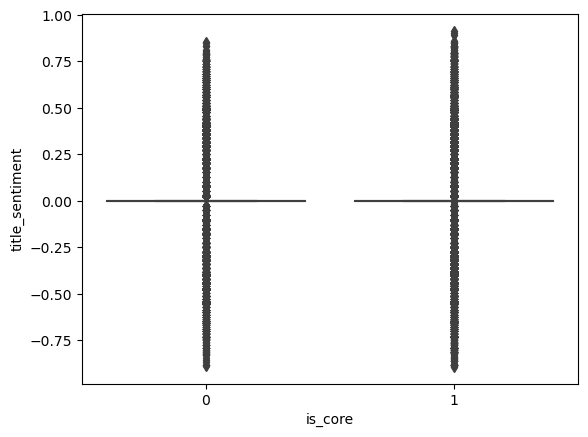

In [18]:
sns.boxplot(x='is_core', y='title_sentiment', data=pr_titles)

<Axes: xlabel='is_core', ylabel='body_sentiment'>

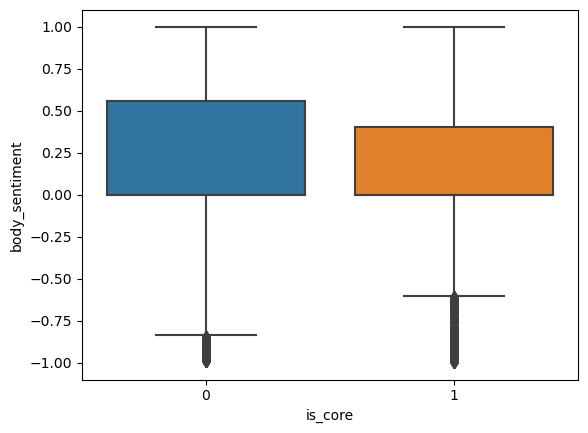

In [19]:
sns.boxplot(x='is_core', y='body_sentiment', data=pr_body)

<Axes: >

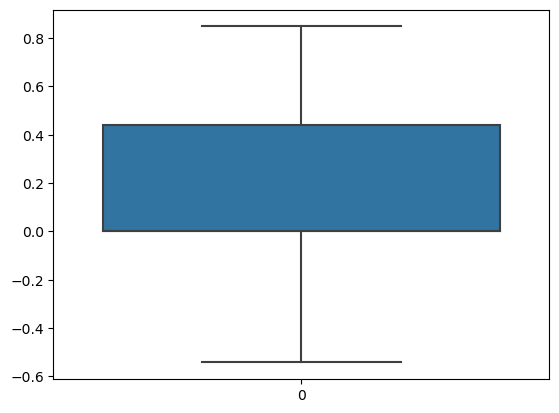

In [20]:
sns.boxplot(pr_body['body_sentiment'], showfliers=False, whis=[5, 95])

In [21]:
np.mean(pr_body['body_sentiment'])

0.16080036904549946

<Axes: xlabel='is_core', ylabel='title_sentiment'>

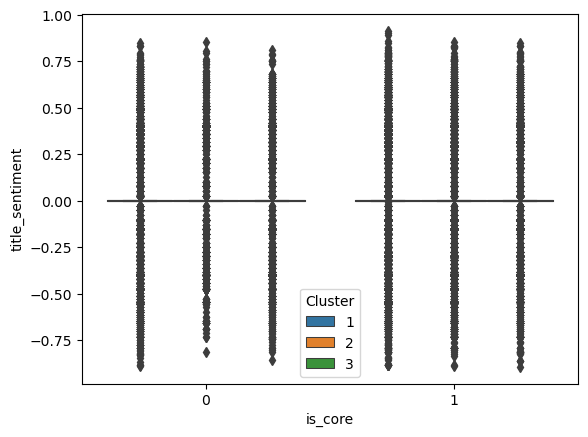

In [22]:
sns.boxplot(x='is_core', y='title_sentiment', hue = 'Cluster', data=pr_titles)

<Axes: xlabel='is_core', ylabel='body_sentiment'>

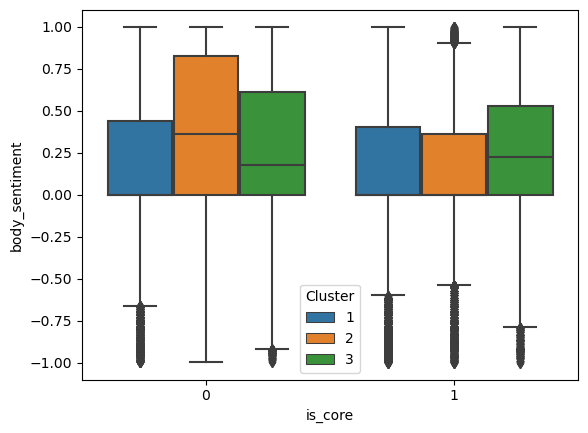

In [23]:
sns.boxplot(x='is_core', y='body_sentiment', hue = 'Cluster', data=pr_body)

In [25]:
c1 = prs[prs['Cluster'] == 1]
c2 = prs[prs['Cluster'] == 2]
c3 = prs[prs['Cluster'] == 3]

c1['is_core'].value_counts()

1    52433
0    33074
Name: is_core, dtype: int64

In [26]:
c2['is_core'].value_counts()

1    25040
0     6948
Name: is_core, dtype: int64

In [27]:
c3['is_core'].value_counts()

1    18423
0    13335
Name: is_core, dtype: int64

In [30]:
def balance_binary_class(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        idx = -1
        
        # Vectorize the data using CountVectorizer
        vectorizer = CountVectorizer()
        X_bow = vectorizer.fit_transform(balanced_data['processed_title'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_bow, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_bow, y, cv=kf, scoring='f1')
        for pred in predictions:
            scores_acc.append(pred)
        for pred in predictions2:
            scores_apre.append(pred)
    return scores_acc, scores_apre

# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc, c1_apre = balance_binary_class(c1, 'is_core')
c2_acc, c2_apre = balance_binary_class(c2, 'is_core')
c3_acc, c3_apre = balance_binary_class(c3, 'is_core')

In [31]:
def balance_binary_class_tf_idf(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        
        # Vectorize the data using TfidfVectorizer
        vectorizer = TfidfVectorizer()
        X_tfidf = vectorizer.fit_transform(balanced_data['processed_title'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='f1')
        
        scores_acc.extend(predictions)
        scores_apre.extend(predictions2)
        
    return scores_acc, scores_apre


# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc_idf, c1_apre_idf = balance_binary_class_tf_idf(c1, 'is_core')
c2_acc_idf, c2_apre_idf = balance_binary_class_tf_idf(c2, 'is_core')
c3_acc_idf, c3_apre_idf = balance_binary_class_tf_idf(c3, 'is_core')

In [32]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
accuracy_title = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
      
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    accuracy_title = pd.concat([accuracy_title, new_row], ignore_index=True)

In [33]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
f1_title = pd.DataFrame(data)

for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    f1_title = pd.concat([f1_title, new_row], ignore_index=True)

In [34]:
def balance_binary_class(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        idx = -1
        
        # Vectorize the data using CountVectorizer
        vectorizer = CountVectorizer()
        X_bow = vectorizer.fit_transform(balanced_data['processed_body'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_bow, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_bow, y, cv=kf, scoring='f1')
        for pred in predictions:
            scores_acc.append(pred)
        for pred in predictions2:
            scores_apre.append(pred)
    return scores_acc, scores_apre

# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc, c1_apre = balance_binary_class(c1, 'is_core')
c2_acc, c2_apre = balance_binary_class(c2, 'is_core')
c3_acc, c3_apre = balance_binary_class(c3, 'is_core')

In [35]:
def balance_binary_class_tf_idf(df, binary_variable):
    np.random.seed(0)
    scores_acc = []
    scores_apre = []
    
    for i in range(100):
        # Identify the minority and majority classes based on counts
        class_counts = df[binary_variable].value_counts()
        minority_class = class_counts.idxmin()
        majority_class = class_counts.idxmax()

        # Separate the data into minority and majority classes
        minority_data = df[df[binary_variable] == minority_class]
        majority_data = df[df[binary_variable] == majority_class]

        # Sample an equal-sized random subset from the majority class
        majority_sample = majority_data.sample(n=len(minority_data))

        # Concatenate the minority samples and the randomly sampled majority samples
        balanced_data = pd.concat([minority_data, majority_sample], ignore_index=True)
        
        # Vectorize the data using TfidfVectorizer
        vectorizer = TfidfVectorizer()
        X_tfidf = vectorizer.fit_transform(balanced_data['processed_body'])
        y = balanced_data['is_core']

        # Initialize a Multinomial Naive Bayes classifier
        classifier = MultinomialNB()

        # Define 10-fold cross-validation
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        # Perform 10-fold cross-validation and get predictions
        predictions = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='accuracy')
        predictions2 = cross_val_score(classifier, X_tfidf, y, cv=kf, scoring='f1')
        
        scores_acc.extend(predictions)
        scores_apre.extend(predictions2)
        
    return scores_acc, scores_apre


# Example usage:
# Assuming 'binary_variable' is the name of your binary variable
c1_acc_idf, c1_apre_idf = balance_binary_class_tf_idf(c1, 'is_core')
c2_acc_idf, c2_apre_idf = balance_binary_class_tf_idf(c2, 'is_core')
c3_acc_idf, c3_apre_idf = balance_binary_class_tf_idf(c3, 'is_core')

In [36]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
accuracy_body = pd.DataFrame(data)

for row in c1_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c2_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c3_acc:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
      
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)
    
for row in c1_acc_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    accuracy_body = pd.concat([accuracy_body, new_row], ignore_index=True)

In [37]:
# Initialize the column names and corresponding empty lists
columns = ['Score', 'Metric', 'Cluster']
data = {col: [] for col in columns}

# Create an empty DataFrame
f1_body = pd.DataFrame(data)

for row in c1_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [1]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c2_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [2]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c3_apre:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [0], 'Cluster': [3]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c1_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [1]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
      
for row in c2_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [2]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)
    
for row in c3_apre_idf:
    new_row = pd.DataFrame({'Score': [row], 'Metric': [1], 'Cluster': [3]})
    f1_body = pd.concat([f1_body, new_row], ignore_index=True)

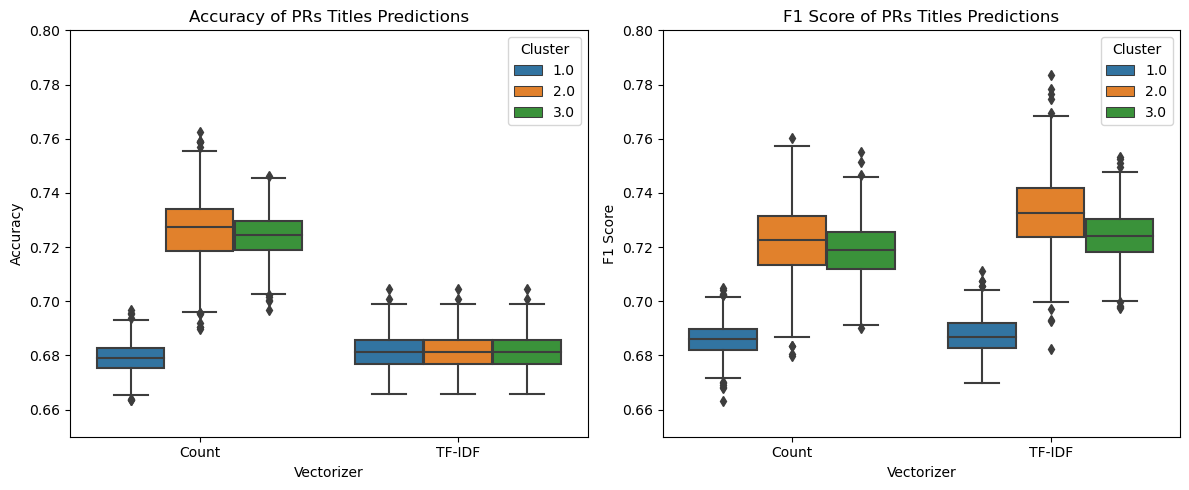

In [44]:
# Create a subplot grid
new_xtick_labels = ['Count', 'TF-IDF']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=accuracy_title, ax=axes[0])
axes[0].set_title('Accuracy of PRs Titles Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.65, 0.8)
axes[0].set_xlabel("Vectorizer")
axes[0].set_ylabel("Accuracy")

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=f1_title, ax=axes[1])
axes[1].set_title('F1 Score of PRs Titles Predictions')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.65, 0.8)
axes[1].set_xlabel("Vectorizer")
axes[1].set_ylabel("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

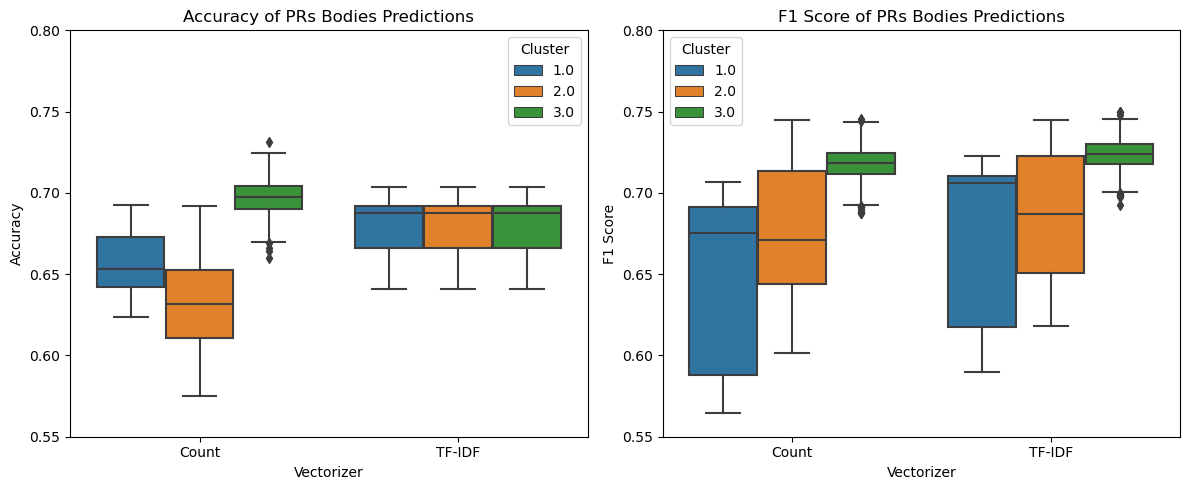

In [43]:
# Create a subplot grid
new_xtick_labels = ['Count', 'TF-IDF']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot the first boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=accuracy_body, ax=axes[0])
axes[0].set_title('Accuracy of PRs Bodies Predictions')
axes[0].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[0].set_xticklabels(new_xtick_labels) 
axes[0].set_ylim(0.55, 0.8)
axes[0].set_xlabel("Vectorizer")
axes[0].set_ylabel("Accuracy")

# Plot the second boxplot
sns.boxplot(x='Metric', y='Score', hue='Cluster', data=f1_body, ax=axes[1])
axes[1].set_title('F1 Score of PRs Bodies Predictions')
axes[1].set_xticks(range(len(new_xtick_labels)))  # Set x-axis ticks
axes[1].set_xticklabels(new_xtick_labels) 
axes[1].set_ylim(0.55, 0.8)
axes[1].set_xlabel("Vectorizer")
axes[1].set_ylabel("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [40]:
vectorizer = CountVectorizer()
core_titles = pr_titles[pr_titles['is_core'] == 1]
title_words = vectorizer.fit_transform(core_titles['processed_title'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts across all documents
word_counts = title_words.sum(axis=0)

# Create a DataFrame to display the top 25 most common words with counts
top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.tolist()[0]})
top_words_df = top_words_df.sort_values(by='Count', ascending=False).head(50)

# Display the top 25 most common words
print(top_words_df)

            Word  Count
5893         fix  22288
137          add  12208
18226      updat  10991
16888       test   6952
18326        use   4826
13904      remov   4670
5718        feat   3826
16452    support   3691
13847     releas   3023
2362       chang   2749
5809        file   2664
4540         doc   2639
1885       build   2543
10746        new   2445
18580    version   2376
2491       chore   2369
5266       error   2369
1942        bump   2288
15021        set   2167
2527          ci   2087
2810        code   1986
127           ad   1973
13728   refactor   1825
7693      improv   1761
9464        make   1673
537          api   1628
17713       type   1589
3359        core   1488
6518         get   1465
9027        link   1452
6473       gener   1451
10588       name   1437
2415       check   1428
8188        issu   1420
11932       page   1370
9201         log   1351
3835        data   1346
7658   implement   1335
3501       creat   1297
3100      config   1253
11759         os

In [41]:
vectorizer = CountVectorizer()
core_titles = pr_titles[pr_titles['is_core'] == 0]
title_words = vectorizer.fit_transform(core_titles['processed_title'])

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Sum the counts across all documents
word_counts = title_words.sum(axis=0)

# Create a DataFrame to display the top 25 most common words with counts
top_words_df = pd.DataFrame({'Word': feature_names, 'Count': word_counts.tolist()[0]})
top_words_df = top_words_df.sort_values(by='Count', ascending=False).head(50)

# Display the top 25 most common words
print(top_words_df)

            Word  Count
4862         fix  12933
122          add   7987
14842      updat   6760
4713        feat   3843
3730         doc   2948
14919        use   2902
13391    support   2072
13753       test   1991
11410      remov   1903
110           ad   1825
1915       chang   1558
8864         new   1275
12257        set   1249
9699        page   1176
4359       error   1174
4789        file   1117
15135    version   1104
14441       type   1095
7475        link   1089
14464       typo   1033
4495      exampl   1015
2466      compon    974
1607      button    922
11285   refactor    903
6356       imprv    889
6355      improv    874
2824       creat    870
2522      config    853
5193    function    828
2272        code    822
1537       build    817
9530      option    807
8741        name    792
2037       chore    789
4715      featur    782
6769        issu    780
14933       user    752
7506        list    729
507          api    725
3293     default    716
6328   implement